In [1]:
import random
import math

### Task 1: The init method initializes all parameters to default values 

The __init__ method now initializes additional instance variables to store the sequences of the forward and reverse primers, as well as their positions. These instance variables will later be useful in referencing when implementing the Simulated Annealing Algorithm later.

In [2]:
class PrimerDesign(object):
    
    def __init__ (self):
        
        '''parameters for the length criterion'''
        self.max_length = 22 #long enough for adequate specificity
        self.min_length = 18 #easily bind to template at annealing temperature
        self.penalty_length = 10 
        
        '''parameters for the temperature difference criterion'''
        self.max_tdiff = 15 #if annealing temperature of forward and reverse primer is too large, primers will not anneal properly
        self.min_tdiff = -5
        self.penalty_tdiff = 10
        
        '''parameters for the cg content criterion'''
        self.max_cg = 0.6 #GC-rich tracts tend to form inverted repeats, or hairpin structures, thus will not anneal properly to the target DNA template
        self.min_cg = 0.4 #AT-rich strectches are hard to amplify under standard reaction conditions
        self.penalty_cg = 10
        
        '''parameters for the annealing temperature criterion'''
        self.max_temp = 65 #if too high, primer might not bind because bonds are broken as they are formed
        self.min_temp = 50 #if too low, primer could bind imperfectly
        self.penalty_temp = 10
        
        '''parameters for the run criterion'''
        self.run_threshold = 4 #likely to have errors in replication
        self.penalty_runs = 10
        
        '''parameters for the repeat criterion'''
        self.repeat_threshold = 2 #likely to have errors in replication
        self.penalty_repeats = 10
        
        '''parameters for the specificity criterion'''
        self.penalty_specificity = 10 
        
        '''locations where the forward primer should be chosen from'''
        self.fp_start = 100
        self.fp_end = 200
        self.fp = None
        self.fp_pos = None
        
        '''locations where the reverse primer should be chosen from'''
        self.rp_start = 300
        self.rp_end = 400
        
        self.rp = None
        self.rp_pos = None 
        
        ''' parameters for the simulated annealing portion'''
        self.initial_temperature = 200
        self.stopping_temperature = 0.01
        self.drop_fraction = 0.99

### Task 2 
This method cleans up an input DNA sequence such that it is left with only its Nucleotides. The parsed sequence will then be stored as an instance variable. 


In [3]:
class PrimerDesign(PrimerDesign): 
    
    def set_dna_sequence(self, dna_sequence):
        #list of bases
        nucleotides = ["a", "t", "c", "g"]
        output_list = []
        
        #checks input DNA sequence for bases and append them to a list
        for char in dna_sequence: 
            if char in nucleotides: 
                output_list.append(char)
        
        #converts list into single line string
        dna_sequence = "".join(output_list)
        self.dna_sequence = dna_sequence
        return self.dna_sequence

Below is an example of a __raw DNA sequence__ input that has not been parsed yet.

In [4]:
test_sq = "1 gtccgggcag cccccggcgc agcgcggccg cagcagcctc cgccccccgc acggtgtgag\
61 cgcccgacgc ggccgaggcg gccggagtcc cgagctagcc ccggcggccg ccgccgccca\
121 gaccggacga caggccacct cgtcggcgtc cgcccgagtc cccgcctcgc cgccaacgcc\
181 acaaccaccg cgcacggccc cctgactccg tccagtattg atcgggagag ccggagcgag\
241 ctcttcgggg agcagcgatg cgaccctccg ggacggccgg ggcagcgctc ctggcgctgc\
301 tggctgcgct ctgcccggcg agtcgggctc tggaggaaaa gaaagtttgc caaggcacga\
361 gtaacaagct cacgcagttg ggcacttttg aagatcattt tctcagcctc cagaggatgt\
421 tcaataactg tgaggtggtc cttgggaatt tggaaattac ctatgtgcag aggaattatg\
481 atctttcctt cttaaagacc atccaggagg tggctggtta tgtcctcatt gccctcaaca\
541 cagtggagcg aattcctttg gaaaacctgc agatcatcag aggaaatatg tactacgaaa\
601 attcctatgc cttagcagtc ttatctaact atgatgcaaa taaaaccgga ctgaaggagc\
661 tgcccatgag aaatttacag gaaatcctgc atggcgccgt gcggttcagc aacaaccctg\
721 ccctgtgcaa cgtggagagc atccagtggc gggacatagt cagcagtgac tttctcagca\
781 acatgtcgat ggacttccag aaccacctgg gcagctgcca aaagtgtgat ccaagctgtc\
841 ccaatgggag ctgctggggt gcaggagagg agaactgcca gaaactgacc aaaatcatct\
901 gtgcccagca gtgctccggg cgctgccgtg gcaagtcccc cagtgactgc tgccacaacc\
961 agtgtgctgc aggctgcaca ggccccatgg agagcgactg cctggtctgc cgcaaattcc\
1021 gagacgaagc cacgtgcaag gacacctgcc ccccactcat gctctacaac cccaccacgt\
1081 accagatgga tgtgaacccc gagggcaaat acagctttgg tgccacctgc gtgaagaagt\
1141 gtccccgtaa ttatgtggtg acagatcacg gctcgtgcgt ccgagcctgt ggggccgaca\
1201 gctatgagat ggaggaagac ggcgtccgca agtgtaagaa gtgcgaaggg ccttgccgca\
1261 aagtgtgtaa cggaataggt attggtgaat ttaaagactc actctccata aatgctacga\
1321 atattaaaca cttcaaaaac tgcacctcca tcagtggcga tctccacatc ctgccggtgg\
1381 catttagggg tgactccttc acacatactc ctcctctgga tccacaggaa ctggatattc\
1441 tgaaaaccgt aaaggaaatc acagggtttt tgctgattca ggcttggcct gaaaacagga\
1501 cggacctcca tgcctttgag aacctagaaa tcatacgcgg caggaccaag caacatggtc\
1561 agttttctct tgcagtcgtc agcctgaaca taacatcctt gggattacgc tccctcaagg\
1621 agataagtga tggagatgtg ataatttcag gaaacaaaaa tttgtgctat gcaaatacaa\
1681 taaactggaa aaaactgttt gggacctccg gtcagaaaac caaaattata agcaacagag\
1741 gtgaaaacag ctgcaaggcc acaggccagg tctgccatgc cttgtgctcc cccgagggct\
1801 gctggggccc ggagcccagg gactgcgtct cttgccggaa tgtcagccga ggcagggaat\
1861 gcgtggacaa gtgcaacctt ctggagggtg agccaaggga gtttgtggag aactctgagt\
1921 gcatacagtg ccacccagag tgcctgcctc aggccatgaa catcacctgc acaggacggg\
1981 gaccagacaa ctgtatccag tgtgcccact acattgacgg cccccactgc gtcaagacct\
2041 gcccggcagg agtcatggga gaaaacaaca ccctggtctg gaagtacgca gacgcttgcc\
2101 atgtgtgcca cctgtgccat ccaaactgca cctacggatg cactgggcca ggtcttgaag\
2161 gctgtccaac gaatgggcct aagatcccgt ccatcgccac tgggatggtg ggggccctcc\
2221 tcttgctgct ggtggtggcc ctggggatcg gcctcttcat gcgaaggcgc cacatcgttc\
2281 ggaagcgcac gctgcggagg ctgctgcagg agagggagct tgtggagcct cttacaccca\
2341 gtggagaagc tcccaaccaa gctctcttga ggatcttgaa ggaaactgaa ttcaaaaaga\
2401 tcaaagtgct gggctccggt gcgttcggca cggtgtataa gggactctgg atcccagaag\
2461 gtgagaaagt taaaattccc gtcgctatca aggaattaag agaagcaaca tctccgaaag\
2521 ccaacaagga aatcctcgat gaagcctacg tgatggccag cgtggacaac ccccacgtgt\
2581 gccgcctgct gggcatctgc ctcacctcca ccgtgcagct catcacgcag ctcatgccct\
2641 tcggctgcct cctggactat gtccgggaac acaaagacaa tattggctcc cagtacctgc\
2701 tcaactggtg tgtgcagatc gcaaagggca tgaactactt ggaggaccgt cgcttggtgc\
2761 accgcgacct ggcagccagg aacgtactgg tgaaaacacc gcagcatgtc aagatcacag\
2821 attttgggct ggccaaactg ctgggtgcgg aagagaaaga ataccatgca gaaggaggca\
2881 aagtgcctat caagtggatg gcattggaat caattttaca cagaatctat acccaccaga\
2941 gtgatgtctg gagctacggg gtgactgttt gggagttgat gacctttgga tccaagccat\
3001 atgacggaat ccctgccagc gagatctcct ccatcctgga gaaaggagaa cgcctccctc\
3061 agccacccat atgtaccatc gatgtctaca tgatcatggt caagtgctgg atgatagacg\
3121 cagatagtcg cccaaagttc cgtgagttga tcatcgaatt ctccaaaatg gcccgagacc\
3181 cccagcgcta ccttgtcatt cagggggatg aaagaatgca tttgccaagt cctacagact\
3241 ccaacttcta ccgtgccctg atggatgaag aagacatgga cgacgtggtg gatgccgacg\
3301 agtacctcat cccacagcag ggcttcttca gcagcccctc cacgtcacgg actcccctcc\
3361 tgagctctct gagtgcaacc agcaacaatt ccaccgtggc ttgcattgat agaaatgggc\
3421 tgcaaagctg tcccatcaag gaagacagct tcttgcagcg atacagctca gaccccacag\
3481 gcgccttgac tgaggacagc atagacgaca ccttcctccc agtgcctgaa tacataaacc\
3541 agtccgttcc caaaaggccc gctggctctg tgcagaatcc tgtctatcac aatcagcctc\
3601 tgaaccccgc gcccagcaga gacccacact accaggaccc ccacagcact gcagtgggca\
3661 accccgagta tctcaacact gtccagccca cctgtgtcaa cagcacattc gacagccctg\
3721 cccactgggc ccagaaaggc agccaccaaa ttagcctgga caaccctgac taccagcagg\
3781 acttctttcc caaggaagcc aagccaaatg gcatctttaa gggctccaca gctgaaaatg\
3841 cagaatacct aagggtcgcg ccacaaagca gtgaatttat tggagcatga ccacggagga\
3901 tagtatgagc cctaaaaatc cagactcttt cgatacccag gaccaagcca cagcaggtcc\
3961 tccatcccaa cagccatgcc cgcattagct cttagaccca cagactggtt ttgcaacgtt\
4021 tacaccgact agccaggaag tacttccacc tcgggcacat tttgggaagt tgcattcctt\
4081 tgtcttcaaa ctgtgaagca tttacagaaa cgcatccagc aagaatattg tccctttgag\
4141 cagaaattta tctttcaaag aggtatattt gaaaaaaaaa aaaagtatat gtgaggattt\
4201 ttattgattg gggatcttgg agtttttcat tgtcgctatt gatttttact tcaatgggct\
4261 cttccaacaa ggaagaagct tgctggtagc acttgctacc ctgagttcat ccaggcccaa\
4321 ctgtgagcaa ggagcacaag ccacaagtct tccagaggat gcttgattcc agtggttctg\
4381 cttcaaggct tccactgcaa aacactaaag atccaagaag gccttcatgg ccccagcagg\
4441 ccggatcggt actgtatcaa gtcatggcag gtacagtagg ataagccact ctgtcccttc\
4501 ctgggcaaag aagaaacgga ggggatggaa ttcttcctta gacttacttt tgtaaaaatg\
4561 tccccacggt acttactccc cactgatgga ccagtggttt ccagtcatga gcgttagact\
4621 gacttgtttg tcttccattc cattgttttg aaactcagta tgctgcccct gtcttgctgt\
4681 catgaaatca gcaagagagg atgacacatc aaataataac tcggattcca gcccacattg\
4741 gattcatcag catttggacc aatagcccac agctgagaat gtggaatacc taaggatagc\
4801 accgcttttg ttctcgcaaa aacgtatctc ctaatttgag gctcagatga aatgcatcag\
4861 gtcctttggg gcatagatca gaagactaca aaaatgaagc tgctctgaaa tctcctttag\
4921 ccatcacccc aaccccccaa aattagtttg tgttacttat ggaagatagt tttctccttt\
4981 tacttcactt caaaagcttt ttactcaaag agtatatgtt ccctccaggt cagctgcccc\
5041 caaaccccct ccttacgctt tgtcacacaa aaagtgtctc tgccttgagt catctattca\
5101 agcacttaca gctctggcca caacagggca ttttacaggt gcgaatgaca gtagcattat\
5161 gagtagtgtg gaattcaggt agtaaatatg aaactagggt ttgaaattga taatgctttc\
5221 acaacatttg cagatgtttt agaaggaaaa aagttccttc ctaaaataat ttctctacaa\
5281 ttggaagatt ggaagattca gctagttagg agcccacctt ttttcctaat ctgtgtgtgc\
5341 cctgtaacct gactggttaa cagcagtcct ttgtaaacag tgttttaaac tctcctagtc\
5401 aatatccacc ccatccaatt tatcaaggaa gaaatggttc agaaaatatt ttcagcctac\
5461 agttatgttc agtcacacac acatacaaaa tgttcctttt gcttttaaag taatttttga\
5521 ctcccagatc agtcagagcc cctacagcat tgttaagaaa gtatttgatt tttgtctcaa\
5581 tgaaaataaa actatattca tttccactct attatgctct caaatacccc taagcatcta\
5641 tactagcctg gtatgggtat gaaagataca aagataaata aaacatagtc cctgattcta\
5701 agaaattcac aatttagcaa aggaaatgga ctcatagatg ctaaccttaa aacaacgtga\
5761 caaatgccag acaggaccca tcagccaggc actgtgagag cacagagcag ggaggttggg\
5821 tcctgcctga ggagacctgg aagggaggcc tcacaggagg atgaccaggt ctcagtcagc\
5881 ggggaggtgg aaagtgcagg tgcatcaggg gcaccctgac cgaggaaaca gctgccagag\
5941 gcctccactg ctaaagtcca cataaggctg aggtcagtca ccctaaacaa cctgctccct\
6001 ctaagccagg ggatgagctt ggagcatccc acaagttccc taaaagttgc agcccccagg\
6061 gggattttga gctatcatct ctgcacatgc ttagtgagaa gactacacaa catttctaag\
6121 aatctgagat tttatattgt cagttaacca ctttcattat tcattcacct caggacatgc\
6181 agaaatattt cagtcagaac tgggaaacag aaggacctac attctgctgt cacttatgtg\
6241 tcaagaagca gatgatcgat gaggcaggtc agttgtaagt gagtcacatt gtagcattaa\
6301 attctagtat ttttgtagtt tgaaacagta acttaataaa agagcaaaag ctaaaaaaaa\
6361 aaaaaaaaa"

### Task 3
This method selects a forward or reverse primer at random with a specified length within the limits defined by the start and end position parameters. The primers are then stored as an instance variable.

In [5]:
import random 

class PrimerDesign(PrimerDesign):
    
    def func_select_random(self, sqtype='forward', length = 20 ):
        
        '''the length has to be a positive number'''
        
        if sqtype == 'forward':
            output_list = []
            start_limit = self.fp_start 
            end_limit = self.fp_end
            #randomly generate a starting position for the primer
            #the length of the primer is accounted for in the end limit
            start_pos = random.randint(start_limit, end_limit-length)
            #generate primer by slicing the dna sequence
            self.fp = self.dna_sequence[start_pos:start_pos+length]
            self.rp_pos = start_pos
            return self.fp 
        
        elif sqtype == 'reverse':
            start_limit = self.rp_start 
            end_limit = self.rp_end
            start_pos= random.randint(start_limit, end_limit-length)
            self.rp = self.dna_sequence[start_pos: start_pos+length]
            self.fp_pos = start_pos
            return self.rp

### Task 4

Below are a series of methods that return the properties of a given primer sequence.

These functions 1. return the length of the given primer sequence, 2. the percentage of c and g nucleotides in the primer sequence, and 3. the optimal temperature based on the composition of nucleotides in the primer. 

In [6]:
class PrimerDesign(PrimerDesign): 
    
    def func_length(self, sq):
        return len(sq)
    
    def func_cg_fraction(self, sq):
        if len(sq) == 0:
            return 0
        count = 0
        #checks primer for c & g and adds to the counter
        for base in sq:
            if base == 'c' or base == 'g':
                count+=1
        return count/len(sq)
    
    def func_temperature(self,sq):
        
        #calculates optimal temperature based on number of each base
        optimal_temp = 4*(sq.count('c') + sq.count('g')) + 2*(sq.count('a') + sq.count('t'))
        return optimal_temp

This method returns the number of same nucleotides that are next to each other. 

In [7]:
class PrimerDesign(PrimerDesign):

    def func_count_runs(self,sq):
        #converts primer string to list
        sq_list = [i for i in sq]
        runs = 0
        count = 0
        base = ' '
        for i in sq_list:
            #adds to count if base is same as previous
            if i == base:
                count += 1
                
            else:
                if count >= self.run_threshold: #checks if count of previous base run exceeds threshold
                    runs += 1 #update number of runs
                count = 0 #resets count for new base
                base = i #if base different from previous, variable base is changed to current base
        if count >= self.run_threshold:
            runs += 1
        return runs

This method returns the number of repeated nucleotide pairs that are right next to each other.

In [8]:
class PrimerDesign(PrimerDesign):
    def func_count_repeats(self,sq):
        di_repeats = ['at','ac','ag','ca','ct','cg','ga','gt','gc','ta','tc','tg']
        repeats = 0
        count = 0

        for i in di_repeats:
            #makes a copy of primer sequence
            x = sq[:]
            while len(x)>= 2:
                #if first 2 characters of sequence is same as di_repeat
                if x[0] + x[1] == i:
                    while len(x) >= 2 and x[0] + x[1] == i:
                        count += 1 #adds to count
                        x = x[2:] #removes first 2 characters
                    
                    #when encounter something that is not the di_repeat checked for, checks if theres a repeat
                    if count > 1:
                        repeats += count - 1
                    count = 0

                    #after encountering the first di_repeat in sequence if not di_repeat, remove first 1 character
                    while len(x) >= 2 and x[0] + x[1] != i:
                        x = x[1:]
                
                #before encountering first di_repeat
                else:
                    x = x[1:]
                    
            #when finish checking for sequence for a di_rpeeat, checks if last part has repeats        
            if count > 1:
                repeats += count -1
            count = 0
            
        return repeats

### Task 5

### This method calculates the cost based on each criteria

In [9]:
class PrimerDesign(PrimerDesign):
    
    def cost_length(self, sq):
        '''This is given to you as an example '''
        sq_len = len(sq)
        if(sq_len > self.max_length):
            return (sq_len - self.max_length)*self.penalty_length
        elif(sq_len > self.min_length):
            return 0
        else:
            return (self.min_length - sq_len)*self.penalty_length 
    
    def cost_temperature(self, sq):
        temp = self.func_temperature(sq)
        if temp > self.max_temp:
            cost_temp = self.penalty_temp*(temp-self.max_temp)
        elif temp > self.min_temp:
            cost_temp = 0
        else:
            cost_temp = self.penalty_temp*(self.min_temp-temp)
        return cost_temp
        
    def cost_cgcontent(self,sq):
        cg_content = self.func_cg_fraction(sq)
        if cg_content > 0.6:
            cost_cgcontent = self.penalty_cg*(cg_content-0.6)
        elif cg_content >= 0.4:
            cost_cgcontent = 0
        else:
            cost_cgcontent = self.penalty_cg*(0.4-cg_content)
        return cost_cgcontent
        
    def cost_temperature_difference(self, fp, rp):
        temp_fp = self.func_temperature(fp)
        temp_rp = self.func_temperature(rp)
        temp_diff = abs(temp_fp-temp_rp)
        if temp_diff > self.max_tdiff:
            cost_temp_diff = self.penalty_tdiff*(temp_diff-self.max_tdiff)
        else:
            cost_temp_diff = 0
        return cost_temp_diff
    
    def cost_specificity(self, sq):
        return self.penalty_specificity*(self.dna_sequence.count(sq)-1)
    
    def cost_runs(self, sq):
        return self.func_count_runs(sq) * self.penalty_runs
    
    def cost_repeats(self,sq):
        return self.func_count_repeats(sq) * self.penalty_repeats

### Task 6

### This method sums the cost for each criteria for both primers

In [10]:
class PrimerDesign(PrimerDesign):
    
    def cost_objective_function(self, fp, rp):
        '''complete the calculation of the cost'''
        
        cost_fp = self.cost_length(fp) + self.cost_temperature(fp) + self.cost_cgcontent(fp) + self.cost_specificity(fp) + self.cost_runs(fp) + self.cost_repeats(fp)
        cost_rp = self.cost_length(rp) + self.cost_temperature(rp) + self.cost_cgcontent(rp) + self.cost_specificity(rp) + self.cost_runs(rp) + self.cost_repeats(rp)
        total_cost = cost_fp + cost_rp + self.cost_temperature_difference(fp,rp)
        return total_cost 

### Task 7

### This method prints a summary of the cost of producing the randomly selected forward and reverse primers

In [11]:
class PrimerDesign(PrimerDesign):
    
    def cost_objective_function_info(self, fp, rp):
        Criterion = ['length','annealing temperature', '%cg_content','specificity','runs','repeats']
        F_Cost = [self.func_length(fp), self.func_temperature(fp), self.cost_cgcontent(fp), self.cost_specificity(fp), self.cost_runs(fp), self.cost_repeats(fp)]
        F_Criterion_Met = ['True' if i==0 else 'False' for i in F_Cost]
        
        R_Cost = [self.func_length(rp), self.func_temperature(rp), self.cost_cgcontent(rp), self.cost_specificity(rp), self.cost_runs(rp), self.cost_repeats(rp)]
        R_Criterion_Met = ['True' if i==0 else 'False' for i in R_Cost]

        line = '{:<80}'.format('===Forward Primer=== {}'.format(fp)) + '\n' 
        line += '{:<25}'.format('Criterion') + '{:>25}'.format('Cost Function Score') + '{:>30}'.format('Criteria Met') + '\n' 
        line += '-'*80 + '\n'
        line += '{:<25}'.format(Criterion[0]) + '{:>25}'.format('{0:.3f}'.format(F_Cost[0])) + '{:>30}'.format(F_Criterion_Met[0]) + '\n'
        line += '{:<25}'.format(Criterion[1]) + '{:>25}'.format('{0:.3f}'.format(F_Cost[1])) + '{:>30}'.format(F_Criterion_Met[1]) + '\n'
        line += '{:<25}'.format(Criterion[2]) + '{:>25}'.format('{0:.3f}'.format(F_Cost[2])) + '{:>30}'.format(F_Criterion_Met[2]) + '\n'
        line += '{:<25}'.format(Criterion[3]) + '{:>25}'.format('{0:.3f}'.format(F_Cost[3])) + '{:>30}'.format(F_Criterion_Met[3]) + '\n'
        line += '{:<25}'.format(Criterion[4]) + '{:>25}'.format('{0:.3f}'.format(F_Cost[4])) + '{:>30}'.format(F_Criterion_Met[4]) + '\n'
        line += '{:<25}'.format(Criterion[5]) + '{:>25}'.format('{0:.3f}'.format(F_Cost[5])) + '{:>30}'.format(F_Criterion_Met[5]) + '\n'
        line += '\n'

        line += '{:<50}'.format('===Reverse Primer=== {}'.format(rp)) + '\n' 
        line += '{:<25}'.format('Criterion') + '{:>25}'.format('Cost Function Score') + '{:>30}'.format('Criteria Met') + '\n' 
        line += '-'*80 + '\n'
        line += '{:<25}'.format(Criterion[0]) + '{:>25}'.format('{0:.3f}'.format(R_Cost[0])) + '{:>30}'.format(R_Criterion_Met[0]) + '\n'
        line += '{:<25}'.format(Criterion[1]) + '{:>25}'.format('{0:.3f}'.format(R_Cost[1])) + '{:>30}'.format(R_Criterion_Met[1]) + '\n'
        line += '{:<25}'.format(Criterion[2]) + '{:>25}'.format('{0:.3f}'.format(R_Cost[2])) + '{:>30}'.format(R_Criterion_Met[2]) + '\n'
        line += '{:<25}'.format(Criterion[3]) + '{:>25}'.format('{0:.3f}'.format(R_Cost[3])) + '{:>30}'.format(R_Criterion_Met[3]) + '\n'
        line += '{:<25}'.format(Criterion[4]) + '{:>25}'.format('{0:.3f}'.format(R_Cost[4])) + '{:>30}'.format(R_Criterion_Met[4]) + '\n'
        line += '{:<25}'.format(Criterion[5]) + '{:>25}'.format('{0:.3f}'.format(R_Cost[5])) + '{:>30}'.format(R_Criterion_Met[5]) + '\n'
        line += '\n'

        line += '{:<25}'.format('Temperature Difference') + '{:>25}'.format('{0:.3f}'.format(self.cost_objective_function(fp,rp))) + '\n'
        
        print (line)

### This method uses pandas to print a similar summary info page

In [12]:
def color_false(s):
    if s == 'False':
        color = 'red'
    elif s == 'True':
        color = 'green'
    else:
        color = 'black'
    return 'color: %s' % color

In [13]:
import pandas as pd

class PrimerDesign(PrimerDesign):
    
    def cost_objective_function_info2(self):
        Criterion = ['length','annealing temperature', '%cg_content','specificity','runs','repeats']
        F_Cost = [self.func_length(self.fp),
                  self.func_temperature(self.fp),
                  self.cost_cgcontent(self.fp),
                  self.cost_specificity(self.fp),
                  self.cost_runs(self.fp),
                  self.cost_repeats(self.fp)]
       
        F_Criterion_Met = ['True' if i==0 else 'False' for i in F_Cost]
        F_Primer = {'Criterion': Criterion, 
                    'Cost Function Score': pd.Series(['{0:.3f}'.format(i) for i in F_Cost], index=[i for i in range(1,7)]), 
                    'Criterion Met':F_Criterion_Met}
        
        R_Cost = [self.func_length(self.rp),
                  self.func_temperature(self.rp),
                  self.cost_cgcontent(self.rp),
                  self.cost_specificity(self.rp),
                  self.cost_runs(self.rp),
                  self.cost_repeats(self.rp)]
        R_Criterion_Met = ['True' if i==0 else 'False' for i in R_Cost]
        
        R_Primer = {'Criterion': Criterion, 
                    'Cost Function Score': pd.Series(['{0:.3f}'.format(i) for i in R_Cost], index=[i for i in range(1,7)]), 
                    'Criterion Met':R_Criterion_Met}
        return (F_Primer, R_Primer)

### Show the outcomes of your functions and testing

#### Store the DNA sequence in the variable below.

In [14]:
dna_sequence = "1 gtccgggcag cccccggcgc agcgcggccg cagcagcctc cgccccccgc acggtgtgag\
61 cgcccgacgc ggccgaggcg gccggagtcc cgagctagcc ccggcggccg ccgccgccca\
121 gaccggacga caggccacct cgtcggcgtc cgcccgagtc cccgcctcgc cgccaacgcc\
181 acaaccaccg cgcacggccc cctgactccg tccagtattg atcgggagag ccggagcgag\
241 ctcttcgggg agcagcgatg cgaccctccg ggacggccgg ggcagcgctc ctggcgctgc\
301 tggctgcgct ctgcccggcg agtcgggctc tggaggaaaa gaaagtttgc caaggcacga\
361 gtaacaagct cacgcagttg ggcacttttg aagatcattt tctcagcctc cagaggatgt\
421 tcaataactg tgaggtggtc cttgggaatt tggaaattac ctatgtgcag aggaattatg\
481 atctttcctt cttaaagacc atccaggagg tggctggtta tgtcctcatt gccctcaaca\
541 cagtggagcg aattcctttg gaaaacctgc agatcatcag aggaaatatg tactacgaaa\
601 attcctatgc cttagcagtc ttatctaact atgatgcaaa taaaaccgga ctgaaggagc\
661 tgcccatgag aaatttacag gaaatcctgc atggcgccgt gcggttcagc aacaaccctg\
721 ccctgtgcaa cgtggagagc atccagtggc gggacatagt cagcagtgac tttctcagca\
781 acatgtcgat ggacttccag aaccacctgg gcagctgcca aaagtgtgat ccaagctgtc\
841 ccaatgggag ctgctggggt gcaggagagg agaactgcca gaaactgacc aaaatcatct\
901 gtgcccagca gtgctccggg cgctgccgtg gcaagtcccc cagtgactgc tgccacaacc\
961 agtgtgctgc aggctgcaca ggccccatgg agagcgactg cctggtctgc cgcaaattcc\
1021 gagacgaagc cacgtgcaag gacacctgcc ccccactcat gctctacaac cccaccacgt\
1081 accagatgga tgtgaacccc gagggcaaat acagctttgg tgccacctgc gtgaagaagt\
1141 gtccccgtaa ttatgtggtg acagatcacg gctcgtgcgt ccgagcctgt ggggccgaca\
1201 gctatgagat ggaggaagac ggcgtccgca agtgtaagaa gtgcgaaggg ccttgccgca\
1261 aagtgtgtaa cggaataggt attggtgaat ttaaagactc actctccata aatgctacga\
1321 atattaaaca cttcaaaaac tgcacctcca tcagtggcga tctccacatc ctgccggtgg\
1381 catttagggg tgactccttc acacatactc ctcctctgga tccacaggaa ctggatattc\
1441 tgaaaaccgt aaaggaaatc acagggtttt tgctgattca ggcttggcct gaaaacagga\
1501 cggacctcca tgcctttgag aacctagaaa tcatacgcgg caggaccaag caacatggtc\
1561 agttttctct tgcagtcgtc agcctgaaca taacatcctt gggattacgc tccctcaagg\
1621 agataagtga tggagatgtg ataatttcag gaaacaaaaa tttgtgctat gcaaatacaa\
1681 taaactggaa aaaactgttt gggacctccg gtcagaaaac caaaattata agcaacagag\
1741 gtgaaaacag ctgcaaggcc acaggccagg tctgccatgc cttgtgctcc cccgagggct\
1801 gctggggccc ggagcccagg gactgcgtct cttgccggaa tgtcagccga ggcagggaat\
1861 gcgtggacaa gtgcaacctt ctggagggtg agccaaggga gtttgtggag aactctgagt\
1921 gcatacagtg ccacccagag tgcctgcctc aggccatgaa catcacctgc acaggacggg\
1981 gaccagacaa ctgtatccag tgtgcccact acattgacgg cccccactgc gtcaagacct\
2041 gcccggcagg agtcatggga gaaaacaaca ccctggtctg gaagtacgca gacgcttgcc\
2101 atgtgtgcca cctgtgccat ccaaactgca cctacggatg cactgggcca ggtcttgaag\
2161 gctgtccaac gaatgggcct aagatcccgt ccatcgccac tgggatggtg ggggccctcc\
2221 tcttgctgct ggtggtggcc ctggggatcg gcctcttcat gcgaaggcgc cacatcgttc\
2281 ggaagcgcac gctgcggagg ctgctgcagg agagggagct tgtggagcct cttacaccca\
2341 gtggagaagc tcccaaccaa gctctcttga ggatcttgaa ggaaactgaa ttcaaaaaga\
2401 tcaaagtgct gggctccggt gcgttcggca cggtgtataa gggactctgg atcccagaag\
2461 gtgagaaagt taaaattccc gtcgctatca aggaattaag agaagcaaca tctccgaaag\
2521 ccaacaagga aatcctcgat gaagcctacg tgatggccag cgtggacaac ccccacgtgt\
2581 gccgcctgct gggcatctgc ctcacctcca ccgtgcagct catcacgcag ctcatgccct\
2641 tcggctgcct cctggactat gtccgggaac acaaagacaa tattggctcc cagtacctgc\
2701 tcaactggtg tgtgcagatc gcaaagggca tgaactactt ggaggaccgt cgcttggtgc\
2761 accgcgacct ggcagccagg aacgtactgg tgaaaacacc gcagcatgtc aagatcacag\
2821 attttgggct ggccaaactg ctgggtgcgg aagagaaaga ataccatgca gaaggaggca\
2881 aagtgcctat caagtggatg gcattggaat caattttaca cagaatctat acccaccaga\
2941 gtgatgtctg gagctacggg gtgactgttt gggagttgat gacctttgga tccaagccat\
3001 atgacggaat ccctgccagc gagatctcct ccatcctgga gaaaggagaa cgcctccctc\
3061 agccacccat atgtaccatc gatgtctaca tgatcatggt caagtgctgg atgatagacg\
3121 cagatagtcg cccaaagttc cgtgagttga tcatcgaatt ctccaaaatg gcccgagacc\
3181 cccagcgcta ccttgtcatt cagggggatg aaagaatgca tttgccaagt cctacagact\
3241 ccaacttcta ccgtgccctg atggatgaag aagacatgga cgacgtggtg gatgccgacg\
3301 agtacctcat cccacagcag ggcttcttca gcagcccctc cacgtcacgg actcccctcc\
3361 tgagctctct gagtgcaacc agcaacaatt ccaccgtggc ttgcattgat agaaatgggc\
3421 tgcaaagctg tcccatcaag gaagacagct tcttgcagcg atacagctca gaccccacag\
3481 gcgccttgac tgaggacagc atagacgaca ccttcctccc agtgcctgaa tacataaacc\
3541 agtccgttcc caaaaggccc gctggctctg tgcagaatcc tgtctatcac aatcagcctc\
3601 tgaaccccgc gcccagcaga gacccacact accaggaccc ccacagcact gcagtgggca\
3661 accccgagta tctcaacact gtccagccca cctgtgtcaa cagcacattc gacagccctg\
3721 cccactgggc ccagaaaggc agccaccaaa ttagcctgga caaccctgac taccagcagg\
3781 acttctttcc caaggaagcc aagccaaatg gcatctttaa gggctccaca gctgaaaatg\
3841 cagaatacct aagggtcgcg ccacaaagca gtgaatttat tggagcatga ccacggagga\
3901 tagtatgagc cctaaaaatc cagactcttt cgatacccag gaccaagcca cagcaggtcc\
3961 tccatcccaa cagccatgcc cgcattagct cttagaccca cagactggtt ttgcaacgtt\
4021 tacaccgact agccaggaag tacttccacc tcgggcacat tttgggaagt tgcattcctt\
4081 tgtcttcaaa ctgtgaagca tttacagaaa cgcatccagc aagaatattg tccctttgag\
4141 cagaaattta tctttcaaag aggtatattt gaaaaaaaaa aaaagtatat gtgaggattt\
4201 ttattgattg gggatcttgg agtttttcat tgtcgctatt gatttttact tcaatgggct\
4261 cttccaacaa ggaagaagct tgctggtagc acttgctacc ctgagttcat ccaggcccaa\
4321 ctgtgagcaa ggagcacaag ccacaagtct tccagaggat gcttgattcc agtggttctg\
4381 cttcaaggct tccactgcaa aacactaaag atccaagaag gccttcatgg ccccagcagg\
4441 ccggatcggt actgtatcaa gtcatggcag gtacagtagg ataagccact ctgtcccttc\
4501 ctgggcaaag aagaaacgga ggggatggaa ttcttcctta gacttacttt tgtaaaaatg\
4561 tccccacggt acttactccc cactgatgga ccagtggttt ccagtcatga gcgttagact\
4621 gacttgtttg tcttccattc cattgttttg aaactcagta tgctgcccct gtcttgctgt\
4681 catgaaatca gcaagagagg atgacacatc aaataataac tcggattcca gcccacattg\
4741 gattcatcag catttggacc aatagcccac agctgagaat gtggaatacc taaggatagc\
4801 accgcttttg ttctcgcaaa aacgtatctc ctaatttgag gctcagatga aatgcatcag\
4861 gtcctttggg gcatagatca gaagactaca aaaatgaagc tgctctgaaa tctcctttag\
4921 ccatcacccc aaccccccaa aattagtttg tgttacttat ggaagatagt tttctccttt\
4981 tacttcactt caaaagcttt ttactcaaag agtatatgtt ccctccaggt cagctgcccc\
5041 caaaccccct ccttacgctt tgtcacacaa aaagtgtctc tgccttgagt catctattca\
5101 agcacttaca gctctggcca caacagggca ttttacaggt gcgaatgaca gtagcattat\
5161 gagtagtgtg gaattcaggt agtaaatatg aaactagggt ttgaaattga taatgctttc\
5221 acaacatttg cagatgtttt agaaggaaaa aagttccttc ctaaaataat ttctctacaa\
5281 ttggaagatt ggaagattca gctagttagg agcccacctt ttttcctaat ctgtgtgtgc\
5341 cctgtaacct gactggttaa cagcagtcct ttgtaaacag tgttttaaac tctcctagtc\
5401 aatatccacc ccatccaatt tatcaaggaa gaaatggttc agaaaatatt ttcagcctac\
5461 agttatgttc agtcacacac acatacaaaa tgttcctttt gcttttaaag taatttttga\
5521 ctcccagatc agtcagagcc cctacagcat tgttaagaaa gtatttgatt tttgtctcaa\
5581 tgaaaataaa actatattca tttccactct attatgctct caaatacccc taagcatcta\
5641 tactagcctg gtatgggtat gaaagataca aagataaata aaacatagtc cctgattcta\
5701 agaaattcac aatttagcaa aggaaatgga ctcatagatg ctaaccttaa aacaacgtga\
5761 caaatgccag acaggaccca tcagccaggc actgtgagag cacagagcag ggaggttggg\
5821 tcctgcctga ggagacctgg aagggaggcc tcacaggagg atgaccaggt ctcagtcagc\
5881 ggggaggtgg aaagtgcagg tgcatcaggg gcaccctgac cgaggaaaca gctgccagag\
5941 gcctccactg ctaaagtcca cataaggctg aggtcagtca ccctaaacaa cctgctccct\
6001 ctaagccagg ggatgagctt ggagcatccc acaagttccc taaaagttgc agcccccagg\
6061 gggattttga gctatcatct ctgcacatgc ttagtgagaa gactacacaa catttctaag\
6121 aatctgagat tttatattgt cagttaacca ctttcattat tcattcacct caggacatgc\
6181 agaaatattt cagtcagaac tgggaaacag aaggacctac attctgctgt cacttatgtg\
6241 tcaagaagca gatgatcgat gaggcaggtc agttgtaagt gagtcacatt gtagcattaa\
6301 attctagtat ttttgtagtt tgaaacagta acttaataaa agagcaaaag ctaaaaaaaa\
6361 aaaaaaaaa"

### Task 8: Improvements made to the summary information page as well as displaying the costs of primers. 

We decided to use the Pandas data frame to output the information, allowing for special features such as colour coding and better data structures for storage of information. The numbers of lines of code in this case is also greatly reduced. 

We also have a __"Criterion Met"__ Column where we can show on first look if the specific criterion of the primer has been met. In this case, a cost function score of more than 0 will result in "False". This condition can be re-defined to the users' needs.

Lastly, Panda's data frame is more visually appealing than typical print outputs.

In [15]:
test = PrimerDesign()
test.set_dna_sequence(test_sq)
test.func_select_random("forward", length = 20)
test.func_select_random("reverse", length = 20)

print('Forward Primer = {}'.format(test.fp))
pd.DataFrame.from_dict(test.cost_objective_function_info2()[0])[['Criterion', 'Cost Function Score', 'Criterion Met']].style.applymap(color_false)

Forward Primer = ggcgtccgcccgagtccccg


,Criterion,Cost Function Score,Criterion Met
1,length,20.000,False
2,annealing temperature,74.000,False
3,%cg_content,2.500,False
4,specificity,0.000,True
5,runs,0.000,True
6,repeats,0.000,True


In [16]:
print('Reverse Primer = {}'.format(test.rp))
pd.DataFrame.from_dict(test.cost_objective_function_info2()[1])[['Criterion', 'Cost Function Score', 'Criterion Met']].style.applymap(color_false)

Reverse Primer = gaaagtttgccaaggcacga


,Criterion,Cost Function Score,Criterion Met
1,length,20.000,False
2,annealing temperature,60.000,False
3,%cg_content,0.000,True
4,specificity,0.000,True
5,runs,0.000,True
6,repeats,0.000,True


### Task 10 Bonus: Implementation of Simulated Annealing Algorithm

A special feature of my optimization algorithm is that I merged the "Neighbour-finding" function inside the main function. The iteration of position to find a "neighbour" candidate is done based on percentage - 2 percent as I have defined. For example, if the solution space for the primer is spans 100 nucleotides, each jump will be from 0 - 2 nucleotides. This is less arbitary than fixing an absolute range regardless of the size of the solution space, i.e. the space where the ideal primer candidates can be found. 

Of course 2% was defined by me based on empirical feedbacks. I find that a range of 2% is helps the algorithm find local and global minimums of cost effectively. 

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt
class PrimerDesign(PrimerDesign): 
#     def get_primer_neighbour(fp): 
        
    def func_simulated_annealing(self):
        
        temperature = self.initial_temperature
        stopping_temperature = self.stopping_temperature
        drop = self.drop_fraction
        
        fp_length = len(self.fp)
        rp_length = len(self.rp)
        fp_position = self.fp_pos
        rp_position = self.rp_pos
        
        fp_current = self.fp
        rp_current = self.rp
        current_cost = self.cost_objective_function(fp_current, rp_current)
        
#         Jump 2 percent of the entire solution space 
        jump_interval_fp = round(abs(self.fp_start - self.fp_end)/100 * 2)
        jump_interval_rp = round(abs(self.rp_start - self.rp_end)/100 * 2)
        count = 0 
        counts = []
        costs = []
        while temperature > stopping_temperature: 
            
            fp_position += (random.randint(-jump_interval_fp, jump_interval_fp))
            rp_position += (random.randint(-jump_interval_rp, jump_interval_rp))
            fp_new = self.dna_sequence[fp_position: fp_position+fp_length]
            rp_new = self.dna_sequence[rp_position: rp_position+rp_length]
            new_cost = self.cost_objective_function(fp_new, rp_new)
            prob = None
            
            if new_cost < current_cost: 
                current_cost = new_cost
                fp_current = fp_new
                rp_current = rp_new 
                
            else: 
                prob = np.exp((current_cost -new_cost)/temperature)
                if prob > random.random(): 
                    fp_current = fp_new
                    rp_current = rp_new
                    current_cost = new_cost 
            count+=1 
            counts.append(count)
            costs.append(current_cost)
            temperature *= drop
            
#             print("Iteration: {}, Cost: {}, fp: {}, rp:{}, acceptance probability{}".\
#                   format(count, current_cost, fp_current, rp_current, prob))
        
        plt.plot(counts, costs)
#         print(costs)
#         print(costs)
        plt.xlabel("Iterations")
        plt.ylabel("Cost Function")
        plt.title("Final Cost: {}".format(current_cost))
        plt.show()
            
            
        


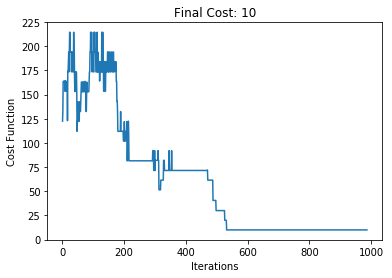

In [23]:
bonus = PrimerDesign()
bonus.set_dna_sequence(test_sq)
bonus.func_select_random("forward", length = 20)
bonus.func_select_random("reverse", length = 20)
bonus.func_simulated_annealing()